In [47]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
metadata_df = pd.read_csv("train_metadata.csv", index_col="sample")
data_df = pd.read_csv("train_data.csv",  index_col="sample")

In [3]:
metadata_df.columns

Index(['baboon_id', 'collection_date', 'sex', 'age', 'social_group',
       'group_size', 'rain_month_mm', 'season', 'hydro_year', 'month',
       'diet_PC1', 'diet_PC2', 'diet_PC3', 'diet_PC4', 'diet_PC5', 'diet_PC6',
       'diet_PC7', 'diet_PC8', 'diet_PC9', 'diet_PC10', 'diet_PC11',
       'diet_PC12', 'diet_PC13'],
      dtype='object')

full correlation between moth and season - no need to take both
6-10 - wet else dry.



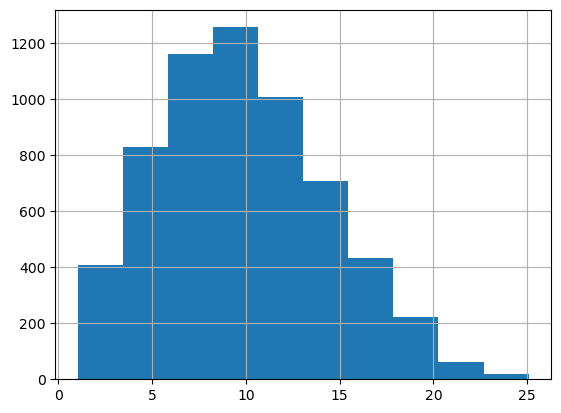

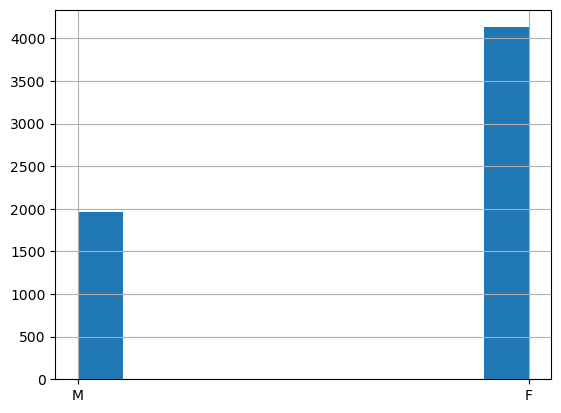

In [4]:
metadata_df["age"].hist()

plt.show()
metadata_df["sex"].hist()

plt.show()


In [5]:
metadata_df_M = metadata_df[metadata_df["sex"]=="M"]
metadata_df_F = metadata_df[metadata_df["sex"]=="F"]

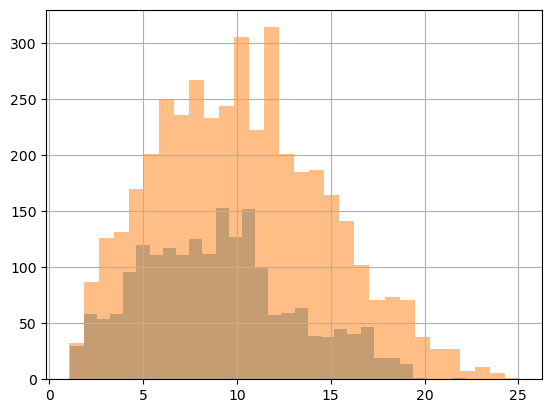

In [6]:
metadata_df_M["age"].hist(bins = 30, alpha=0.5)

metadata_df_F["age"].hist(bins=30, alpha=0.5)

plt.show()

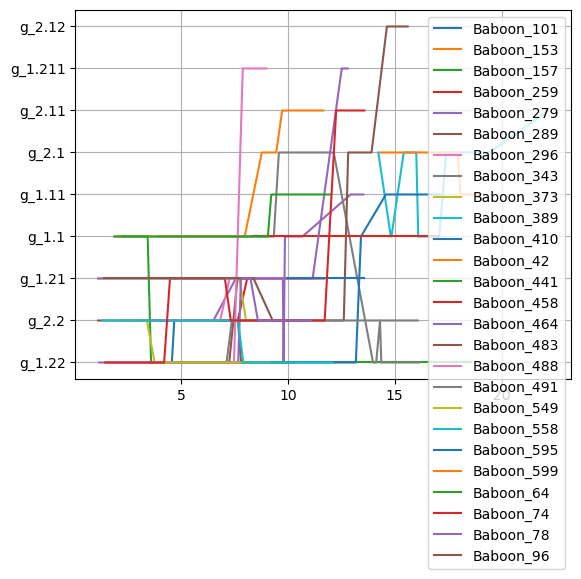

In [7]:
for baboon in metadata_df_M["baboon_id"].unique():
    age = metadata_df_M["age"][metadata_df_M["baboon_id"] == baboon]
    social_group = metadata_df_M["social_group"][metadata_df_M["baboon_id"] == baboon]
    plt.plot(age, social_group, label=baboon)
    
plt.grid()
plt.legend()
plt.show()

In [8]:
# make sure the data is sorted by sample date
metadata_df_M.sort_values(by=["baboon_id","collection_date"], inplace=True)


C:\Users\yuvald\AppData\Local\Temp\ipykernel_37932\3969196945.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df_M.sort_values(by=["baboon_id","collection_date"], inplace=True)


In [9]:
# for each baboon - summig  up the number of social group change over the years.
number_of_group_change_M = []
for baboon in metadata_df_M["baboon_id"].unique():
    baboon_df = pd.DataFrame({"social_group":metadata_df_M["social_group"][metadata_df_M["baboon_id"]==baboon]})
    baboon_df["next_social_group"] = baboon_df["social_group"].shift(1)
    group_change = (baboon_df["next_social_group"] != baboon_df["social_group"]).astype('int')
    number_of_group_change_M.append(np.sum(group_change)-1)
    
number_of_group_change_F = []
for baboon in metadata_df_F["baboon_id"].unique():
    baboon_df = pd.DataFrame({"social_group":metadata_df_F["social_group"][metadata_df_F["baboon_id"]==baboon]})
    baboon_df["next_social_group"] = baboon_df["social_group"].shift(1)
    group_change = (baboon_df["next_social_group"] != baboon_df["social_group"]).astype('int')
    number_of_group_change_F.append(np.sum(group_change)-1)



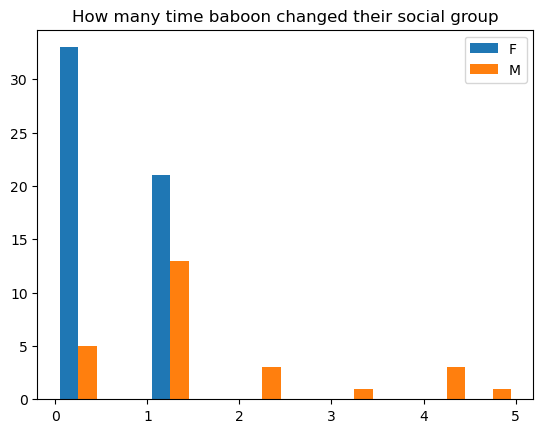

In [10]:
plt.hist([number_of_group_change_F,number_of_group_change_M], label=["F","M"])
plt.legend()
plt.title("How many time baboon changed their social group")
plt.show()

In [11]:
np.mean(metadata_df.groupby("baboon_id")["collection_date"].count())

76.2

1. clustering baboons by averege microbiome profile.
2. changes in samples throughout time for each baboon.

In [12]:
# add baboon_id column
data_df["baboon_id"] = metadata_df["baboon_id"]

data_df_avg = data_df.groupby("baboon_id").mean()

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:36<00:00,  4.57s/it]


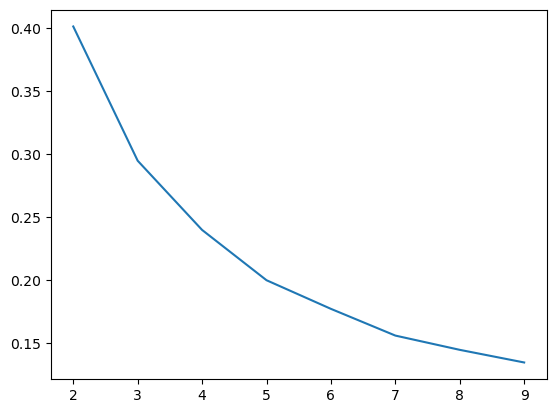

In [18]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
from sklearn.cluster import KMeans


distortions = []
for k in tqdm(range(2, 10)):
    val = 0
    for _ in range(10):
        kmeans = KMeans(n_clusters=k, n_init=10)
        kmeans.fit(data_df_avg.values)
        val += kmeans.inertia_
    
    distortions.append(val/10)
plt.plot(range(2,10),distortions)



In [109]:
kmean = KMeans(n_clusters=3, n_init=10)
labels = kmean.fit(data_df_avg.values).labels_

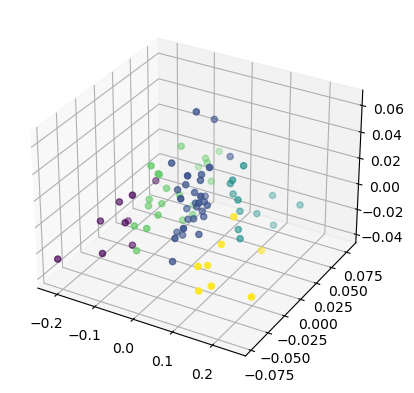

In [60]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
results = pca.fit_transform(data_df_avg).transpose()

ax = plt.axes(projection="3d")
ax.scatter3D(results[0], results[1],results[2], c=labels)
plt.grid()
plt.show()

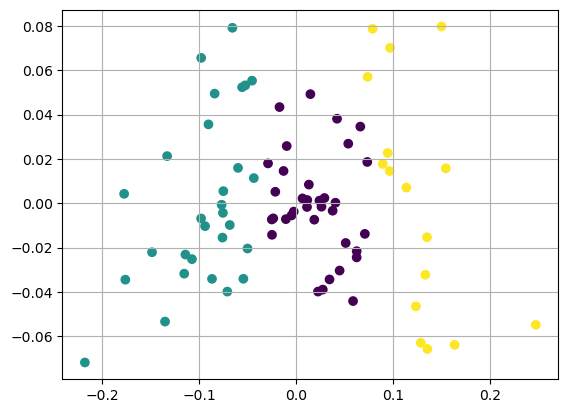

In [110]:
pca = PCA(n_components=2)
results = pca.fit_transform(data_df_avg).transpose()

plt.scatter(results[0], results[1], c=labels)
plt.grid()
plt.show()

In [62]:
import umap

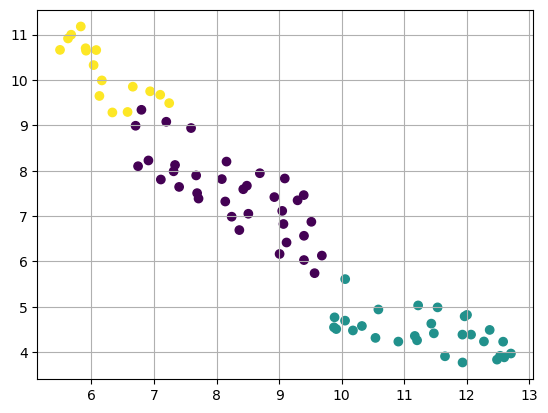

In [112]:
reducer = umap.UMAP()
results = reducer.fit_transform(data_df_avg.values).transpose()

plt.scatter(results[0], results[1], c=labels)
plt.grid()
plt.show()

In [113]:
metadata_df_F["season"]

sample
sample_12051-TGCTCCGTAGAA-408    dry
sample_11408-ACGTGAGGAACG-395    wet
sample_11408-TTACACAAAGGC-395    wet
sample_11408-ACGCTTAACGAC-395    wet
sample_11406-CACCATCTCCGG-394    wet
                                ... 
sample_12050-TACTAACGCGGT-407    wet
sample_11410-ACAGTTGTACGC-396    wet
sample_11413-ACCAGAAATGTC-397    dry
sample_11413-GTTCAACAGCTG-397    dry
sample_11407-GAAGATCTATCG-394    dry
Name: season, Length: 4129, dtype: object

In [114]:
metadata_df_D_F = metadata_df_F[metadata_df_F["season"]=="dry"]
metadata_df_W_F = metadata_df_F[metadata_df_F["season"]=="wet"]
metadata_df_D_M = metadata_df_M[metadata_df_M["season"]=="dry"]
metadata_df_W_M = metadata_df_M[metadata_df_M["season"]=="wet"]

In [137]:
data_df["season"] = metadata_df["season"]
data_df_avg_season = data_df.groupby(["baboon_id","season"]).mean()


C:\Users\yuvald\AppData\Local\Temp\ipykernel_37932\2421974916.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_df_avg_season = data_df.groupby(["baboon_id","season"]).mean()


In [138]:
data_df_avg_season

g_[Eubacterium]_coprostanoligenes_group  \
baboon_id  season                                            
Baboon_101 dry                                    0.005094   
           wet                                    0.011036   
Baboon_107 dry                                    0.009995   
           wet                                    0.004845   
Baboon_109 dry                                    0.013020   
...                                                    ...   
Baboon_74  wet                                    0.007402   
Baboon_78  dry                                    0.008425   
           wet                                    0.007352   
Baboon_96  dry                                    0.004068   
           wet                                    0.006376   

                   g_[Eubacterium]_hallii_group  \
baboon_id  season                                 
Baboon_101 dry                         0.001309   
           wet                         0.004261   
Baboon_107 dry                         0.002206   
           wet                         0.000949   
Baboon_109 dry                         0.000605   
...                                         ...   
Baboon_74  wet                         0.005109   
Baboon_78  dry                         0.000080   
           wet                         0.003407   
Baboon_96  dry                         0.000147   
           wet                         0.002668   

                   g_[Eubacterium]_ruminantium_group  g_Acidaminococcus  \
baboon_id  season                                                         
Baboon_101 dry                              0.002298           0.009125   
           wet                              0.002450           0.010689   
Baboon_107 dry                              0.002401           0.015972   
           wet                              0.000964           0.006553   
Baboon_109 dry                              0.001860           0.002965   
...                                              ...                ...   
Baboon_74  wet                              0.001456           0.008233   
Baboon_78  dry                              0.001400           0.007107   
           wet                              0.002949           0.007105   
Baboon_96  dry                              0.001689           0.004174   
           wet                              0.002626           0.006553   

                   g_Alloprevotella  g_Bifidobacterium  g_Butyricicoccus  \
baboon_id  season                                                          
Baboon_101 dry             0.026972           0.368902          0.002958   
           wet             0.017808           0.409165          0.001801   
Baboon_107 dry             0.014341           0.329833          0.002428   
           wet             0.018351           0.466389          0.001449   
Baboon_109 dry             0.014433           0.224420          0.001022   
...                             ...                ...               ...   
Baboon_74  wet             0.022743           0.396981          0.001429   
Baboon_78  dry             0.017058           0.227466          0.002657   
           wet             0.019085           0.407334          0.002246   
Baboon_96  dry             0.019513           0.466223          0.001020   
           wet             0.015001           0.469113          0.001551   

                   g_CAG-873  g_Campylobacter  g_Candidatus_Methanogranum  \
baboon_id  season                                                           
Baboon_101 dry      0.021509         0.000825                    0.082495   
           wet      0.003090         0.001801                    0.058232   
Baboon_107 dry      0.014162         0.000022                    0.093448   
           wet      0.004933         0.000199                    0.057441   
Baboon_109 dry      0.032498         0.000148                    0.097351   
...                      ...              ..

In [145]:
metadata_df_M["baboon_id"].unique()

array(['Baboon_101', 'Baboon_153', 'Baboon_157', 'Baboon_259',
       'Baboon_279', 'Baboon_289', 'Baboon_296', 'Baboon_343',
       'Baboon_373', 'Baboon_389', 'Baboon_410', 'Baboon_42',
       'Baboon_441', 'Baboon_458', 'Baboon_464', 'Baboon_483',
       'Baboon_488', 'Baboon_491', 'Baboon_549', 'Baboon_558',
       'Baboon_595', 'Baboon_599', 'Baboon_64', 'Baboon_74', 'Baboon_78',
       'Baboon_96'], dtype=object)

In [163]:
data_df_avg_M_D = data_df_avg_season.loc[(metadata_df_M["baboon_id"].unique(),'dry'),:]
data_df_avg_M_W = data_df_avg_season.loc[(metadata_df_M["baboon_id"].unique(),'wet'),:]
data_df_avg_F_D = data_df_avg_season.loc[(metadata_df_F["baboon_id"].unique(),'dry'),:]
data_df_avg_F_W = data_df_avg_season.loc[(metadata_df_F["baboon_id"].unique(),'wet'),:]

In [175]:
data_df_avg_season.loc?

In [188]:
data_df_avg_M_D["sex"] = 0
data_df_avg_F_D["sex"] = 1
data_df_avg_M_W["sex"] = 0
data_df_avg_F_W["sex"] = 1

data_df_avg_D = pd.concat([data_df_avg_M_D, data_df_avg_F_D])
data_df_avg_W = pd.concat([data_df_avg_M_W, data_df_avg_F_W])



data_df_avg_D

C:\Users\yuvald\AppData\Local\Temp\ipykernel_37932\2891893000.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_avg_M_D["sex"] = 0
C:\Users\yuvald\AppData\Local\Temp\ipykernel_37932\2891893000.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_avg_F_D["sex"] = 1
C:\Users\yuvald\AppData\Local\Temp\ipykernel_37932\2891893000.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

,,g_[Eubacterium]_coprostanoligenes_group,g_[Eubacterium]_hallii_group,g_[Eubacterium]_ruminantium_group,g_Acidaminococcus,g_Alloprevotella,g_Bifidobacterium,g_Butyricicoccus,g_CAG-873,g_Campylobacter,g_Candidatus_Methanogranum,...,g_Ruminococcaceae_UCG-013,g_Ruminococcaceae_UCG-014,g_Ruminococcus_1,g_Senegalimassilia,g_Slackia,g_Solobacterium,g_Streptococcus,g_Succinivibrio,g_Treponema_2,sex
baboon_id,season,,,,,,,,,,,,,,,,,,,,,
Baboon_101,dry,0.005094,0.001309,0.002298,0.009125,0.026972,0.368902,0.002958,0.021509,0.000825,0.082495,...,0.001149,0.015703,0.009789,0.001594,0.000384,0.003190,0.000833,0.002713,0.019588,0
Baboon_153,dry,0.009107,0.002018,0.002351,0.006262,0.018420,0.378736,0.001609,0.012238,0.000872,0.070576,...,0.002339,0.018955,0.013790,0.001036,0.000640,0.004883,0.001368,0.014619,0.016434,0
Baboon_157,dry,0.006472,0.001939,0.001163,0.010060,0.023398,0.522649,0.002949,0.002953,0.000006,0.029215,...,0.001042,0.000221,0.009378,0.002097,0.001023,0.006965,0.001214,0.001527,0.003645,0
Baboon_259,dry,0.007642,0.000949,0.001729,0.006204,0.021412,0.307425,0.002210,0.038673,0.001675,0.090602,...,0.002016,0.024534,0.008794,0.001131,0.000693,0.003345,0.000328,0.003516,0.005630,0
Baboon_279,dry,0.006791,0.000915,0.002324,0.008061,0.014902,0.310969,0.001277,0.027453,0.000128,0.102138,...,0.002403,0.028473,0.012305,0.000676,0.000538,0.002146,0.000235,0.012693,0.006485,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Baboon_526,dry,0.010476,0.002204,0.003694,0.013518,0.030539,0.176113,0.001264,0.037189,0.000302,0.082006,...,0.003868,0.021340,0.018415,0.001122,0.000689,0.003056,0.000846,0.002498,0.036027,1
Baboon_534,dry,0.009485,0.002483,0.003090,0.006012,0.008265,0.325604,0.001219,0.021089,0.000193,0.103077,...,0.003080,0.048595,0.007724,0.000823,0.000630,0.005407,0.000117,0.003797,0.038139,1
Baboon_544,dry,0.005510,0.000318,0.001666,0.002259,0.019344,0.480369,0.001500,0.024226,0.001729,0.058826,...,0.000685,0.012327,0.008987,0.001586,0.001119,0.003043,0.000559,0.001664,0.013258,1


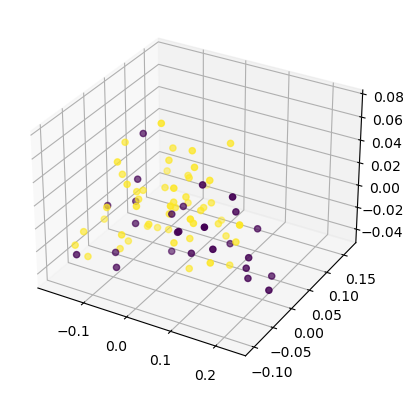

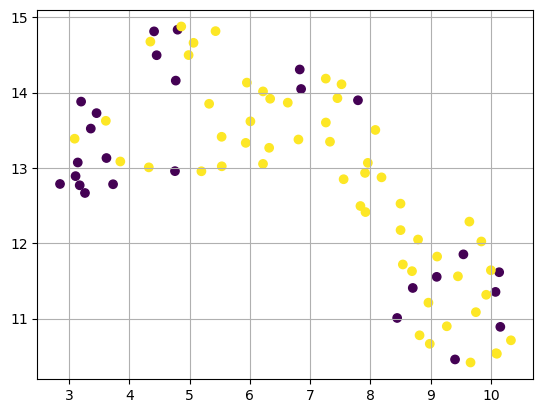

In [232]:
labels = data_df_avg_D["sex"].values
pca = PCA(n_components=3)
results = pca.fit_transform(data_df_avg_D.drop(columns="sex")).transpose()


ax = plt.axes(projection="3d")
ax.scatter3D(results[0], results[1],results[2], c=labels)
plt.grid()
plt.show()


# plt.scatter(results[0], results[1], c=labels)
# plt.grid()
# plt.show()



reducer = umap.UMAP()
results = reducer.fit_transform(data_df_avg_D.drop(columns="sex").values).transpose()

plt.scatter(results[0], results[1], c=labels)
plt.grid()
plt.show()

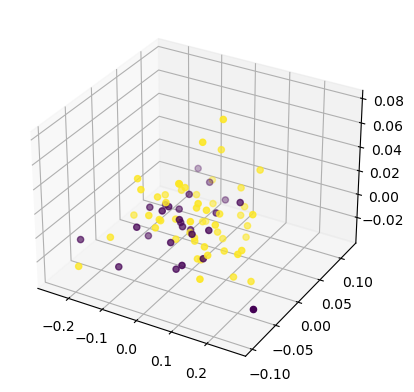

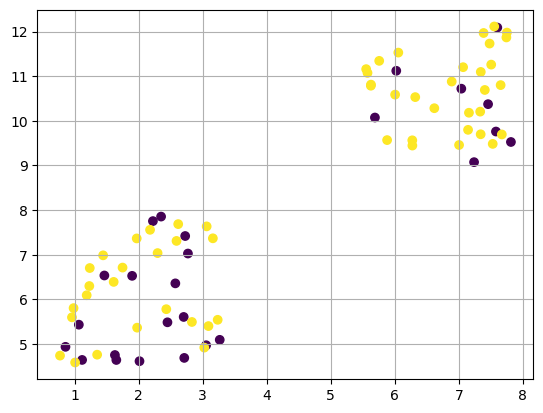

In [233]:
labels = data_df_avg_W["sex"].values
pca = PCA(n_components=3)
results = pca.fit_transform(data_df_avg_W.drop(columns="sex")).transpose()


ax = plt.axes(projection="3d")
ax.scatter3D(results[0], results[1],results[2], c=labels)
plt.grid()
plt.show()


# plt.scatter(results[0], results[1], c=labels)
# plt.grid()
# plt.show()

reducer = umap.UMAP()
results = reducer.fit_transform(data_df_avg_W.drop(columns="sex").values).transpose()

plt.scatter(results[0], results[1], c=labels)
plt.grid()
plt.show()

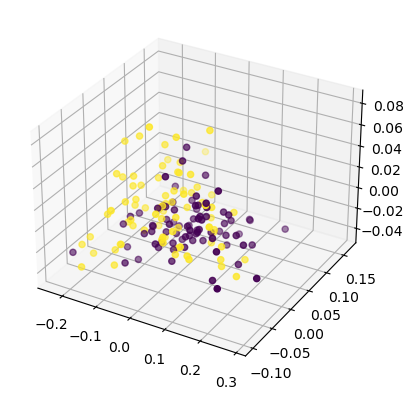

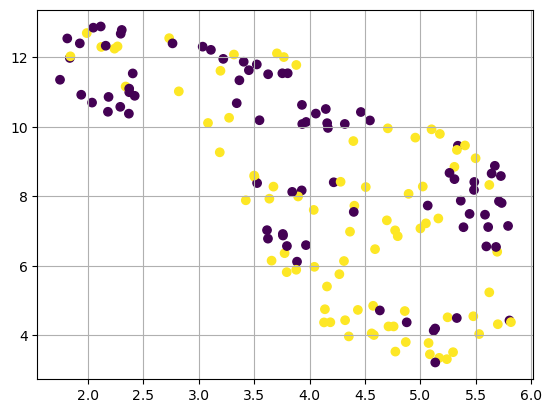

In [234]:
labels = [data_df_avg_season.reset_index()["season"]=='dry']
pca = PCA(n_components=3)
results = pca.fit_transform(data_df_avg_season).transpose()


ax = plt.axes(projection="3d")
ax.scatter3D(results[0], results[1],results[2], c=labels)
plt.grid()
plt.show()


reducer = umap.UMAP()
results = reducer.fit_transform(data_df_avg_season.values).transpose()

plt.scatter(results[0], results[1], c=labels)
plt.grid()
plt.show()

In [235]:
data_df_avg_D
data_df_avg_W

,,g_[Eubacterium]_coprostanoligenes_group,g_[Eubacterium]_hallii_group,g_[Eubacterium]_ruminantium_group,g_Acidaminococcus,g_Alloprevotella,g_Bifidobacterium,g_Butyricicoccus,g_CAG-873,g_Campylobacter,g_Candidatus_Methanogranum,...,g_Ruminococcaceae_UCG-013,g_Ruminococcaceae_UCG-014,g_Ruminococcus_1,g_Senegalimassilia,g_Slackia,g_Solobacterium,g_Streptococcus,g_Succinivibrio,g_Treponema_2,sex
baboon_id,season,,,,,,,,,,,,,,,,,,,,,
Baboon_101,wet,0.011036,0.004261,0.002450,0.010689,0.017808,0.409165,0.001801,0.003090,0.001801,0.058232,...,0.002880,0.019803,0.007492,0.001910,0.001232,0.013969,0.000800,0.005534,0.004503,0
Baboon_153,wet,0.006732,0.002282,0.003369,0.008776,0.013554,0.372789,0.001144,0.009616,0.001430,0.080452,...,0.002047,0.015288,0.010959,0.001051,0.000862,0.005478,0.000943,0.011168,0.005363,0
Baboon_157,wet,0.004000,0.001849,0.001224,0.006582,0.021531,0.608796,0.001298,0.001254,0.000177,0.015665,...,0.000851,0.002776,0.004485,0.002037,0.001303,0.005961,0.003128,0.001262,0.002107,0
Baboon_259,wet,0.007824,0.002426,0.002659,0.004937,0.022625,0.325511,0.001508,0.011738,0.003539,0.070729,...,0.003940,0.027237,0.009744,0.001221,0.001071,0.004893,0.001109,0.006858,0.010649,0
Baboon_279,wet,0.009591,0.003718,0.002310,0.007906,0.017224,0.380400,0.001992,0.011351,0.003853,0.059893,...,0.002256,0.023385,0.012245,0.001514,0.000982,0.005190,0.001033,0.008989,0.003815,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Baboon_526,wet,0.013386,0.008966,0.005042,0.006021,0.020027,0.253291,0.003045,0.010990,0.001692,0.080395,...,0.004595,0.022090,0.018502,0.001139,0.001605,0.006453,0.002268,0.012883,0.009208,1
Baboon_534,wet,0.010894,0.003829,0.003028,0.004793,0.010717,0.346950,0.001892,0.002644,0.002974,0.058097,...,0.003885,0.026137,0.009539,0.001845,0.001672,0.011040,0.001030,0.014224,0.008265,1
Baboon_544,wet,0.006544,0.004096,0.003550,0.002857,0.022749,0.380132,0.002971,0.002731,0.002524,0.045305,...,0.002218,0.013529,0.011530,0.001707,0.001946,0.006359,0.001571,0.005049,0.004463,1


### changes in samples throughout time for each baboon.

In [98]:
data_df["collection_date"] = metadata_df["collection_date"]
data_df.sort_values(by=["baboon_id","collection_date"],inplace=True)

In [107]:
df = data_df[data_df["baboon_id"]=="Baboon_101"]

In [108]:
df=df.drop(columns=["baboon_id"])
df.set_index("collection_date").diff()

,g_[Eubacterium]_coprostanoligenes_group,g_[Eubacterium]_hallii_group,g_[Eubacterium]_ruminantium_group,g_Acidaminococcus,g_Alloprevotella,g_Bifidobacterium,g_Butyricicoccus,g_CAG-873,g_Campylobacter,g_Candidatus_Methanogranum,...,g_Ruminococcaceae_UCG-011,g_Ruminococcaceae_UCG-013,g_Ruminococcaceae_UCG-014,g_Ruminococcus_1,g_Senegalimassilia,g_Slackia,g_Solobacterium,g_Streptococcus,g_Succinivibrio,g_Treponema_2
collection_date,,,,,,,,,,,,,,,,,,,,,
2001-05-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-05-19,-0.037300,-0.001774,-0.001072,0.001171,0.006466,0.271521,-0.000131,0.012992,-0.001050,-0.002128,...,-0.000507,-0.009330,-0.027050,-0.006377,0.001464,-0.001004,-0.000705,-0.002200,0.000596,0.000000
2001-05-23,-0.043675,0.000345,-0.000340,0.000085,0.032295,-0.137200,-0.000340,-0.013371,0.000157,0.011501,...,0.000000,-0.002206,-0.002418,0.006869,-0.002116,-0.000123,-0.000507,-0.000001,-0.001362,0.000000
2001-07-30,-0.009222,-0.000345,0.001596,-0.000840,-0.035118,0.043729,0.003920,0.023659,0.004595,0.085918,...,0.000173,-0.000316,0.014118,-0.007348,0.000416,-0.000973,-0.000296,-0.000188,-0.000754,0.000000
2001-08-06,-0.000811,0.000000,-0.000982,0.002656,-0.019874,0.163878,0.000586,-0.019129,-0.004752,-0.021876,...,-0.000173,-0.000312,-0.006539,0.003717,0.000977,0.000369,0.001160,0.000000,0.001925,0.000451
2001-08-15,0.000533,0.000000,0.011019,0.005304,0.004961,-0.026702,-0.001656,-0.000628,0.001687,0.002214,...,0.000000,0.000291,-0.006531,0.016584,-0.001393,0.000038,0.000996,0.000000,-0.001925,-0.000451
2001-08-17,0.001372,0.000000,-0.010609,-0.003715,0.059248,0.026867,-0.002440,0.006151,-0.001380,0.024852,...,0.000000,-0.000291,0.003255,-0.019512,0.000359,-0.000407,-0.002369,0.000000,0.000000,0.000000
2001-08-18,0.003042,0.000000,0.005504,-0.003542,0.029838,-0.134871,0.000398,0.006453,-0.000307,0.029517,...,0.000187,0.000000,0.002102,0.005006,-0.000172,0.000000,0.000190,0.000000,0.000000,0.000000
2001-09-20,-0.002320,0.000000,-0.004093,0.005613,-0.009495,-0.025362,0.001052,0.014019,0.000531,-0.055900,...,-0.000010,0.000797,0.053784,0.006887,-0.000187,0.000797,0.002780,0.000266,0.000000,0.000221
